In [1]:
%load_ext autoreload
%autoreload 2

from primitives.primitives import *
from primitives.tv_model import *
from primitives.spinful import *

from cirq import Circuit, LineQid, measure, sample, Simulator
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy.constants import hbar
from scipy.linalg import ishermitian
import datetime
import time

simulator = Simulator()

line_styles = ['-.', '--', '-.', ':']*3
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']*2

## Operators

In [2]:
mat_B_up = 1j * sy_gamma_1 * sy_gamma_2  # (r)
mat_B_do = 1j * sy_gamma_3 * sy_gamma_4  # (r)

mat_x_A_up = 1j * TensorProduct(sy_gamma_5*sy_gamma_2, sy_gamma_5, sy_gamma_2)  # (r, r', r+x)
mat_x_A_do = 1j * TensorProduct(sy_gamma_5*sy_gamma_4, sy_gamma_5, sy_gamma_4)  # (r, r', r+x)
     
mat_y_A_up = TensorProduct(sy_gamma_5*sy_gamma_2, sy_gamma_1, sy_gamma_5*sy_gamma_2, sy_gamma_2)  # (r, r', r+y, r'+y)
mat_y_A_do = TensorProduct(sy_gamma_5*sy_gamma_4, sy_gamma_3, sy_gamma_5*sy_gamma_4, sy_gamma_4)  # (r, r', r+y, r'+y)

mat_x_hop_up = (-1j/2) * mat_x_A_up * (TensorProduct(mat_B_up, sy_id, sy_id) - TensorProduct(sy_id, sy_id, mat_B_up))  # (r, r', r+x)
mat_x_hop_do = (-1j/2) * mat_x_A_do * (TensorProduct(mat_B_do, sy_id, sy_id) - TensorProduct(sy_id, sy_id, mat_B_do))  # (r, r', r+x)

mat_y_hop_up = (-1j/2) * mat_y_A_up * (TensorProduct(mat_B_up, sy_id, sy_id, sy_id) - TensorProduct(sy_id, sy_id, mat_B_up, sy_id))  # (r, r', r+y, r'+y)
mat_y_hop_do = (-1j/2) * mat_y_A_do * (TensorProduct(mat_B_do, sy_id, sy_id, sy_id) - TensorProduct(sy_id, sy_id, mat_B_do, sy_id))  # (r, r', r+y, r'+y)

mat_single_num_up = (1/2) * (sy_id + mat_B_up)
mat_single_num_do = (1/2) * (sy_id + mat_B_do)
mat_ham_num_do = mat_single_num_up * mat_single_num_do

# r - r' - r+x
mat_spin2_create_up = (1j/4) * TensorProduct(sy_id+mat_B_up, sy_id, sy_id+mat_B_up) * mat_x_A_up
mat_spin2_create_do = (1j/4) * TensorProduct(sy_id+mat_B_do, sy_id, sy_id+mat_B_do) * mat_x_A_do

spin2_G_up = TensorProduct(
    sy_gamma_5,  # r+x
    sy_gamma_5,  # r+x+y
    sy_gamma_5*sy_gamma_1,  # r'
    sy_gamma_1,  # r'+x
    sy_gamma_2,  # r'+x+y
    sy_gamma_5*sy_gamma_2  # r'+y
)
spin2_G_do = TensorProduct(
    sy_gamma_5,  # r+x    
    sy_gamma_5,  # r+x+ya 
    sy_gamma_5*sy_gamma_3,  # r'
    sy_gamma_3,  # r'+x
    sy_gamma_4,  # r'+x+y
    sy_gamma_5*sy_gamma_4  # r'+y
)

In [3]:
class Spin2HopXGateUp(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4, 4)
    def _unitary_(self):
        return np.array(mat_x_hop_up, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H_x(r)u", "H_x(r')u", "H_x(r+x)u"]
class Spin2HopXGateDo(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4, 4)
    def _unitary_(self):
        return np.array(mat_x_hop_do, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H_x(r)d", "H_x(r')d", "H_x(r+x)d"]

In [4]:
class Spin2HopYGateUp(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4, 4, 4)
    def _unitary_(self):
        return np.array(mat_y_hop_up, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H_y(r)u", "H_y(r')u", "H_y(r+y)u", "H_y(r'+y)u"]
class Spin2HopYGateDo(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4, 4, 4)
    def _unitary_(self):
        return np.array(mat_y_hop_do, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H_y(r)d", "H_y(r')d", "H_y(r+y)d", "H_y(r'+y)d"]

In [5]:
class Spin2NumGate(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4,)
    def _unitary_(self):
        return np.array(mat_ham_num_do, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H(up)*H(do)"]

In [6]:
class Spin2ProjectGUp(Gate):
    """Project G consraint in +1"""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        mat = np.array(spin2_G_up, dtype=np.complex128)
        return (np.eye(mat.shape[0]) + mat) / 2
    def _circuit_diagram_info_(self, args):
        return ["P+(r+x)", "P+(r+x+y)", "P+(r')", "P+(r'+x)", "P+(r'+x+y)", "P+(r'+y)"]
class Spin2ProjectGDo(Gate):
    """Project G consraint in +1"""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        mat = np.array(spin2_G_do, dtype=np.complex128)
        return (np.eye(mat.shape[0]) + mat) / 2
    def _circuit_diagram_info_(self, args):
        return ["P+(r+x)", "P+(r+x+y)", "P+(r')", "P+(r'+x)", "P+(r'+x+y)", "P+(r'+y)"]

In [7]:
class Spin2ProjectGUpMin(Gate):
    """Project G consraint in +1"""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        mat = np.array(spin2_G_up, dtype=np.complex128)
        return (np.eye(mat.shape[0]) - mat) / 2
    def _circuit_diagram_info_(self, args):
        return ["P(r+x)", "P(r+x+y)", "P(r')", "P(r'+x)", "P(r'+x+y)", "P(r'+y)"]
class Spin2ProjectGDoMin(Gate):
    """Project G consraint in +1"""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        mat = np.array(spin2_G_do, dtype=np.complex128)
        return (np.eye(mat.shape[0]) - mat) / 2
    def _circuit_diagram_info_(self, args):
        return ["P(r+x)", "P(r+x+y)", "P(r')", "P(r'+x)", "P(r'+x+y)", "P(r'+y)"]

In [8]:
class Spin2CreateGateUp(Gate):
    """Create two up fermions gate."""
    def _qid_shape_(self):
        return (4, 4, 4)
    def _unitary_(self):
        return np.array(mat_spin2_create_up, dtype=np.complex128) 
    def _circuit_diagram_info_(self, args):
        return ["f+_up", "/", "f+_up"]
class Spin2CreateGateDo(Gate):
    """Create two down fermions gate."""
    def _qid_shape_(self):
        return (4, 4, 4)
    def _unitary_(self):
        return np.array(mat_spin2_create_do, dtype=np.complex128) 
    def _circuit_diagram_info_(self, args):
        return ["f+_do", "/", "f+_do"]

In [9]:
class Spin2CreateGateDiagUp(Gate):
    """Create two up fermions gate."""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        return np.array(
            TensorProduct(sy_id, sy_id, mat_y_hop_up) * 
            TensorProduct(mat_spin2_create_up, sy_id, sy_id, sy_id),
            dtype=np.complex128) 
    def _circuit_diagram_info_(self, args):
        return ["f+_up", "/", "/", "/", "f+_up", "/"]
class Spin2CreateGateDiagDo(Gate):
    """Create two up fermions gate."""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        return np.array(
            TensorProduct(sy_id, sy_id, mat_y_hop_do) * 
            TensorProduct(mat_spin2_create_do, sy_id, sy_id, sy_id),
            dtype=np.complex128) 
    def _circuit_diagram_info_(self, args):
        return ["f+_do", "/", "/", "/", "f+_up", "/"]

In [10]:
class Spin2CreateGateSupUp(Gate):
    """Create two up fermions gate."""
    def _qid_shape_(self):
        return (4, 4, 4, 4, 4, 4)
    def _unitary_(self):
        a = np.array(TensorProduct(mat_spin2_create_up, sy_id, sy_id, sy_id), dtype=np.complex128) 
        b = np.array(
            TensorProduct(sy_id, sy_id, mat_y_hop_up) * 
            TensorProduct(mat_spin2_create_up, sy_id, sy_id, sy_id),
            dtype=np.complex128) 
        return a+b
    def _circuit_diagram_info_(self, args):
        return ["f+_up", "/", "/", "/", "f+_up", "/"]

In [11]:
def add_hopping_circuit(qudits, evolution_circuit, ev_xhop, ev_yhop):
    rows, cols, _ = qudits.shape

    for row in range(rows):
        for col in range(cols):
            # horizontal interaction
            if col != cols - 1:
                a = qudits[row][col]
                b = qudits[row][col+1]
                evolution_circuit.append(ev_xhop[0](a[0], a[1], b[0]))  # spin up
                evolution_circuit.append(ev_xhop[1](a[0], a[1], b[0]))  # spin down
            # vertical interaction
            if row != rows - 1:
                a = qudits[row][col]
                b = qudits[row+1][col]
                evolution_circuit.append(ev_yhop[0](a[0], a[1], b[0], b[1]))  # spin up
                evolution_circuit.append(ev_yhop[1](a[0], a[1], b[0], b[1]))  # spin down

def add_numbers_circuit(qudits, evolution_circuit, ev_num):
    rows, cols, _ = qudits.shape
    
    # On-site part
    for row in range(rows):
        for col in range(cols):
            evolution_circuit.append(ev_num(qudits[row][col][0]))

def evolve(qudits, temps, initial, J, U):

    if len(temps) > 1:
        ev_num = evolve_gate(Spin2NumGate)(C=U, t = temps[1]-temps[0])
        ev_xhop = [
            evolve_gate(Spin2HopXGateUp)(C=J, t = (temps[1]-temps[0])/2),
            evolve_gate(Spin2HopXGateDo)(C=J, t = (temps[1]-temps[0])/2)
        ]
        ev_yhop = [
            evolve_gate(Spin2HopYGateUp)(C=J, t = (temps[1]-temps[0])/2),
            evolve_gate(Spin2HopYGateDo)(C=J, t = (temps[1]-temps[0])/2)
        ]

    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):

        if t != 0:
            add_hopping_circuit(qudits, evolution_circuit, ev_xhop, ev_yhop)
            add_numbers_circuit(qudits, evolution_circuit, ev_num)
            add_hopping_circuit(qudits, evolution_circuit, ev_xhop, ev_yhop),

        circuit = Circuit([*initial, *evolution_circuit])
        results.append((circuit, simulator.simulate(circuit)))
            
    return results

### Evolve a lattice

In [12]:
def get_spin_plaquettes(qudits):
    rows, cols, _ = qudits.shape
    plaquettes = []
    for row in range(rows):
        for col in range(cols):
            if col != cols - 1 and row != rows - 1:
                pl = [
                    qudits[row][col + 1][0],
                    qudits[row + 1][col + 1][0],
                    
                    qudits[row][col][1],
                    qudits[row][col + 1][1],
                    qudits[row + 1][col + 1][1],
                    qudits[row + 1][col][1],
                ]    
                plaquettes.append(pl)
    return plaquettes

In [13]:
def spin2_compute_state_exp_numbers(qudits, state):
    rows, cols, _ = qudits.shape
    nums = []
    for row in range(rows):
        for col in range(cols):
            val_up = expectation_value(state[1], [qudits[row][col][0]], mat_single_num_up)
            val_do = expectation_value(state[1], [qudits[row][col][0]], mat_single_num_do)
            nums.append((val_up, val_do))
    return nums

In [14]:
def spin2_compute_state_exp_hamiltonian_fh(qudits, state, J, U):
    ham_k = 0
    ham_p = 0

    x_hop_couples = []
    y_hop_couples = []

    rows, cols, _ = qudits.shape
    for row in range(rows):
        for col in range(cols):
            if row != rows - 1:
                # (r - r' - r+y - r'+y)
                y_hop_couples.append([qudits[row][col][0], qudits[row][col][1], qudits[row + 1][col][0],  qudits[row + 1][col][1]])
            if col != cols - 1:
                # (r - r' - r+x)
                x_hop_couples.append([qudits[row][col][0], qudits[row][col][1], qudits[row][col + 1][0]])

    # number term
    for row in range(rows):
        for col in range(cols):
            ham_p += expectation_value(
                state[1], [qudits[row][col][0]], U * mat_ham_num_do
            )

    # x_hop term
    for couple in x_hop_couples:
        ham_k += expectation_value(state[1], couple, J*mat_x_hop_up)
        ham_k += expectation_value(state[1], couple, J*mat_x_hop_do)

    # y_hop term
    for couple in y_hop_couples:
        ham_k += expectation_value(state[1], couple, J*mat_y_hop_up)
        ham_k += expectation_value(state[1], couple, J*mat_y_hop_do)

    return ham_k, ham_p

In [15]:
J = -1
U = 0.5

rows = 2
columns = 3
qudits = np.array(LineQid.range(rows * columns * 2, dimension=4)).reshape(rows, columns, 2)

In [16]:
final_T = 0.6
num_steps = 1
dt = final_T / num_steps

temps = [0] # np.arange(0, final_T+dt/2, dt)

plaquettes = get_spin_plaquettes(qudits)
projected_subspace_up = [Spin2ProjectGUp()(*pl) for pl in plaquettes]
projected_subspace_do = [Spin2ProjectGDo()(*pl) for pl in plaquettes]
init = [Id()(qud) for qud in qudits.flatten()]

initial_state = [
    Spin2CreateGateSupUp()(
        qudits[0][0][0], qudits[0][0][1],
        qudits[0][1][0], qudits[0][1][1],
        qudits[1][1][0], qudits[1][1][1]),
    Spin2CreateGateDo()(qudits[0][0][0], qudits[0][0][1], qudits[0][1][0]),
]

initial_circuit = [*init, *projected_subspace_up, *projected_subspace_do, *initial_state]

# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qudits, temps, initial_circuit, J, U)

In [17]:
results[0][0]

0 (d=4): ────I───────────────────────────────────────────────────────f+_up───f+_do───
                                                                     │       │
1 (d=4): ────I───P+(r')────────────────────P+(r')────────────────────/───────/───────
                 │                         │                         │       │
2 (d=4): ────I───P+(r+x)───────────────────P+(r+x)───────────────────/───────f+_do───
                 │                         │                         │
3 (d=4): ────I───P+(r'+x)─────P+(r')───────P+(r'+x)─────P+(r')───────/───────────────
                 │            │            │            │            │
4 (d=4): ────I───┼────────────P+(r+x)──────┼────────────P+(r+x)──────┼───────────────
                 │            │            │            │            │
5 (d=4): ────I───┼────────────P+(r'+x)─────┼────────────P+(r'+x)─────┼───────────────
                 │            │            │            │            │
6 (d=4): ────I───┼────────────┼────────────┼────────────┼────────────┼───────────────
                 │            │            │            │            │
7 (d=4): ────I───P+(r'+y)─────┼────────────P+(r'+y)─────┼────────────┼───────────────
                 │            │            │            │            │
8 (d=4): ────I───P+(r+x+y)────┼────────────P+(r+x+y)────┼────────────f+_up───────────
                 │            │            │            │            │
9 (d=4): ────I───P+(r'+x+y)───P+(r'+y)─────P+(r'+x+y)───P+(r'+y)─────/───────────────
                              │                         │
10 (d=4): ───I────────────────P+(r+x+y)─────────────────P+(r+x+y)────────────────────
                              │                         │
11 (d=4): ───I────────────────P+(r'+x+y)────────────────P+(r'+x+y)───────────────────

In [18]:
ham_k, ham_p = spin2_compute_state_exp_hamiltonian_fh(qudits, results[-1], J, U)
ham_k, ham_p

(-1.0, 0.75)

In [19]:
v = results[0][1].state_vector()
(np.zeros(v.shape) == v).all()

False

In [20]:
v

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)

### Operators

(-1.1, 1.1)

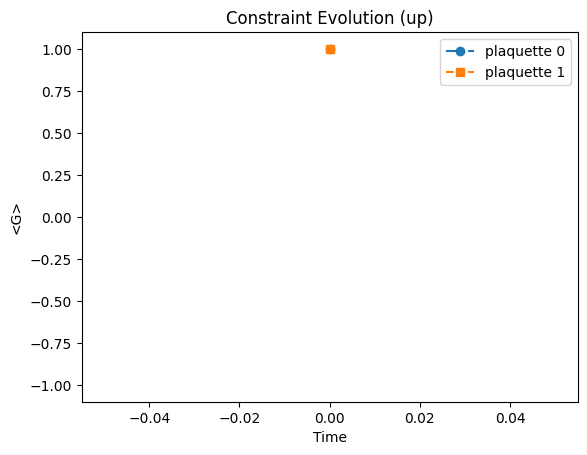

In [21]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    for state in results:
        operator = spin2_G_up
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(val)

for idx, i in enumerate(evol_res):
    plt.plot(temps, evol_res[i], label=f"plaquette {idx}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution (up)")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

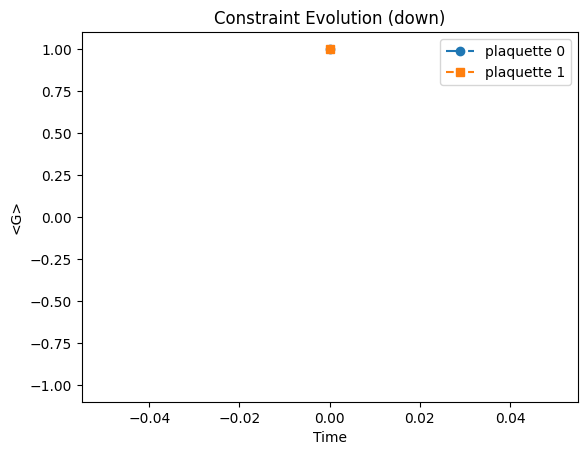

In [22]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    for state in results:
        operator = spin2_G_do
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(val)

for idx, i in enumerate(evol_res):
    plt.plot(temps, evol_res[i], label=f"plaquette {idx}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution (down)")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

### Numbers

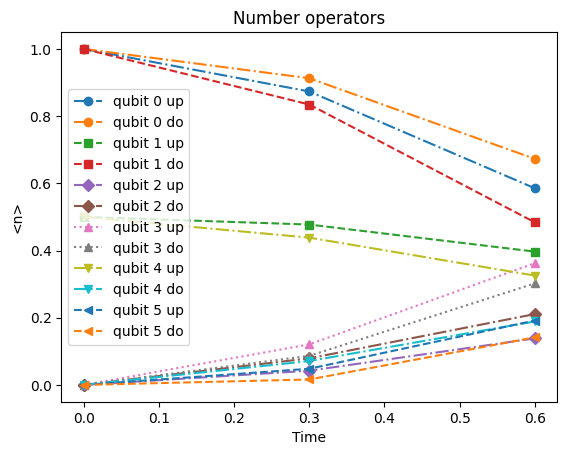

In [47]:
num_evol_res = []

for idx, state in enumerate(results):
    nums = spin2_compute_state_exp_numbers(qudits, state)
    num_evol_res.append(nums)
    
num_evol_res = np.array(num_evol_res)

for i in range(len(qudits.flatten())//2):
    plt.plot(temps, num_evol_res[:,i,0], label=f"qubit {i} up", linestyle=line_styles[i], marker=markers[i])
    plt.plot(temps, num_evol_res[:,i,1], label=f"qubit {i} do", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

In [48]:
np.sum(num_evol_res, axis=1)

array([[2.        , 2.        ],
       [1.99999993, 2.00000003],
       [1.99999927, 1.99999991]])

### Hamiltonian

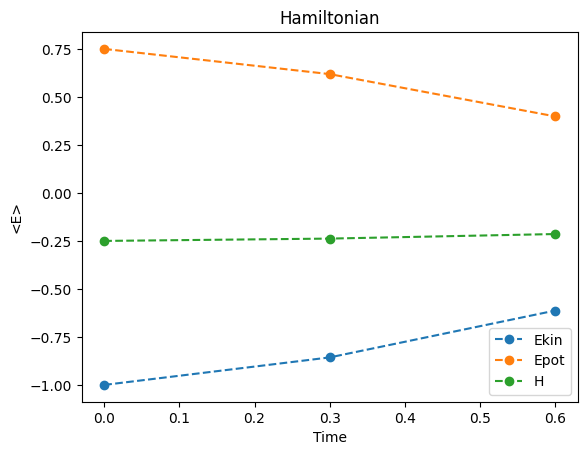

In [49]:
ekin = []
epot = []

for state in results:
    ham_k, ham_p = spin2_compute_state_exp_hamiltonian_fh(qudits, state, J, U)
    ekin.append(ham_k)
    epot.append(ham_p)

ekin = np.array(ekin)
epot = np.array(epot)

plt.plot(temps, ekin, "o--", label="Ekin")
plt.plot(temps, epot, "o--", label="Epot")
plt.plot(temps, ekin+epot, "o--", label="H")
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")
plt.legend()

In [50]:
ekin, epot

(array([-1.        , -0.85673361, -0.61278571]),
 array([0.75      , 0.61885768, 0.39863557]))

## Check Trotterization

In [40]:
final_T = 0.6

nums_steps = [1, 2]

final_results_k = []
final_results_p = []
final_results_h = []
final_results_nums = []

def print_time():
    ts = time.time()
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

for num_steps in nums_steps:
    print(f"Doing {num_steps} steps\t\t{print_time()}")
    
    dt = final_T / num_steps
    temps = np.arange(0, final_T+dt/2, dt)
    # results is a list of tuples, every tuple contains the circuit and the result shots
    results = evolve(qudits, temps, initial_circuit, J=J, U=U)

    print(f"Computing hamiltonian\t\t{print_time()}")
    ham_k, ham_p = spin2_compute_state_exp_hamiltonian_fh(qudits, results[-1], J, U)
    final_results_k.append(ham_k)
    final_results_p.append(ham_p)
    final_results_h.append(ham_k+ham_p)
    
    print(f"Computing nums\t\t{print_time()}")
    nums = spin2_compute_state_exp_numbers(qudits, results[-1])
    nums = np.array(nums)
    final_results_nums.append(np.append(nums[:,0], nums[:,1]))

Doing 1 steps		2024-08-22 19:41:33
Computing hamiltonian		2024-08-22 20:43:18
Computing nums		2024-08-22 20:44:36
Doing 2 steps		2024-08-22 20:44:38
Computing hamiltonian		2024-08-22 22:25:54
Computing nums		2024-08-22 22:27:15


In [46]:
final_results_nums[-1]

array([0.58541454, 0.39676986, 0.13835877, 0.36236793, 0.3254795 ,
       0.19160867, 0.67284866, 0.48406233, 0.21079106, 0.30213599,
       0.18875879, 0.14140306])

Text(0.5, 1.0, 'Tot error on nums')

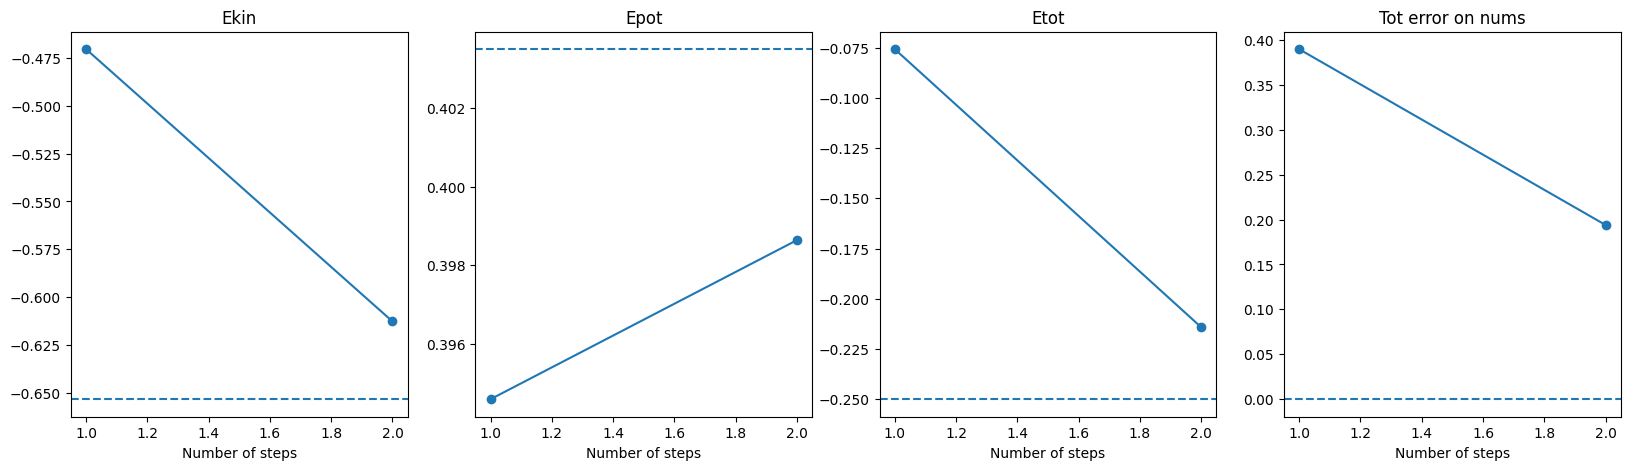

In [51]:
# Tmax = 0.6


nk_val_k = -0.6535
nk_val_p = 0.4035
nk_val_h = nk_val_k+nk_val_p

nk_numbers = np.array([0.593, 0.3805, 0.1461, 0.3784,
                       0.3389, 0.1631, 0.6637, 0.4916,
                       0.2107, 0.3077, 0.2278, 0.0984])


nk_val_h = nk_val_k+nk_val_p

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

final_results_k = np.array(final_results_k)
final_results_p = np.array(final_results_p)

ax1.plot(nums_steps, final_results_k, "-o", label="Ekin")
ax1.axhline(nk_val_k, linestyle="--", label="NK kin")
ax1.set_xlabel("Number of steps")
ax1.set_title("Ekin")

ax2.plot(nums_steps, final_results_p, "-o", label="Epot")
ax2.axhline(nk_val_p, linestyle="--", label="NK pot")
ax2.set_xlabel("Number of steps")
ax2.set_title("Epot")

ax3.plot(nums_steps, final_results_h, "-o", label="Etot")
ax3.axhline(nk_val_h, linestyle="--", label="NK tot")
ax3.set_xlabel("Number of steps")
ax3.set_title("Etot")

num_error = [np.sum(np.abs(nk_numbers - i)) for i in final_results_nums]
ax4.plot(nums_steps, num_error, "-o", label="Etot")
ax4.axhline(0, linestyle="--", label="NK tot")
ax4.set_xlabel("Number of steps")
ax4.set_title("Tot error on nums")